# Import libraries

In [2]:
import os
import cv2 # type: ignore
import numpy as np # type: ignore
from skimage.feature import hog # type: ignore
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, # type: ignore
                             roc_curve, auc, adjusted_rand_score, silhouette_score)
import matplotlib.pyplot as plt # type: ignore
from tqdm import tqdm # type: ignore
from scipy.optimize import linear_sum_assignment # type: ignore
from sklearn.decomposition import PCA # type: ignore



# 1. Preprocessing Images Function

In [4]:

def preprocess_cell_image(img, target_size=(64, 64)):

    # 1. Resize
    img = cv2.resize(img, target_size)

    # 2. Color correction in LAB space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 3. CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    lab[..., 0] = clahe.apply(lab[..., 0])

    # Convert back to BGR
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # 4. Gamma correction
    gamma = 1.4
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    img = cv2.LUT(img, table)

    # 5. Unsharp masking
    blur = cv2.GaussianBlur(img, (0, 0), sigmaX=2)
    img = cv2.addWeighted(img, 1.6, blur, -0.6, 0)

    # 6. Bilateral filter
    img = cv2.bilateralFilter(img, d=5, sigmaColor=50, sigmaSpace=50)

    # 7. Morphological operations to enhance cell structures
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    # 8. Normalize to [0, 1]
    img = img.astype("float32") / 255.0

    return img



# Data Visualization

In [7]:
def visualize_preprocessing(data_dir, categories, samples_per_class=3):

    fig, axes = plt.subplots(len(categories), samples_per_class * 2,
                             figsize=(16, 6))

    for cat_idx, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        img_list = os.listdir(path)[:samples_per_class]

        for img_idx, img_name in enumerate(img_list):
            img_path = os.path.join(path, img_name)
            img_original = cv2.imread(img_path)

            if img_original is None:
                continue

            # Original image (resized only)
            img_resized = cv2.resize(img_original, (64, 64))
            img_rgb_original = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

            # Preprocessed image
            img_preprocessed = preprocess_cell_image(img_original)
            img_rgb_processed = (img_preprocessed * 255).astype("uint8")

            # Plot original
            col_original = img_idx * 2
            axes[cat_idx, col_original].imshow(img_rgb_original)
            axes[cat_idx, col_original].axis('off')
            if img_idx == 0:
                axes[cat_idx, col_original].set_title(f'{category}\n(Original)',
                                                      fontsize=10, fontweight='bold')
            else:
                axes[cat_idx, col_original].set_title('Original', fontsize=9)

            # Plot preprocessed
            col_processed = img_idx * 2 + 1
            axes[cat_idx, col_processed].imshow(img_rgb_processed)
            axes[cat_idx, col_processed].axis('off')
            axes[cat_idx, col_processed].set_title('Preprocessed', fontsize=9)

    plt.suptitle('Preprocessing Comparison: Original vs Enhanced Images',
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Load Images

In [10]:
data_dir = r"/kaggle/input/cell-images-for-detecting-malaria/cell_images"
categories = ["Parasitized", "Uninfected"]

# 2. Extract HOG Features

In [11]:
print("\n  Preprocessing + HOG Extraction")

hog_features = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    img_list = os.listdir(path)

    for img_name in tqdm(img_list, desc=f"Processing {category}"):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Apply preprocessing
        img_processed = preprocess_cell_image(img)

        # Convert back to uint8 for HOG
        img_uint8 = (img_processed * 255).astype("uint8")

        # Extract HOG features per channel
        feature = []
        for ch in cv2.split(img_uint8):
            f = hog(ch,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    transform_sqrt=True)
            feature.extend(f)

        hog_features.append(feature)
        labels.append(class_num)

hog_features = np.array(hog_features)
labels = np.array(labels)

print(f"\n Features extracted: {hog_features.shape}")
print(f" Total samples: {len(labels)}")
print(f" Class distribution: {np.bincount(labels)}")





  Preprocessing + HOG Extraction


Processing Uninfected: 100%|██████████| 13780/13780 [04:15<00:00, 53.83it/s]



 Features extracted: (27558, 5292)
 Total samples: 27558
 Class distribution: [13779 13779]


# Visualize Data Before &After


 Visualizing Preprocessing Effect


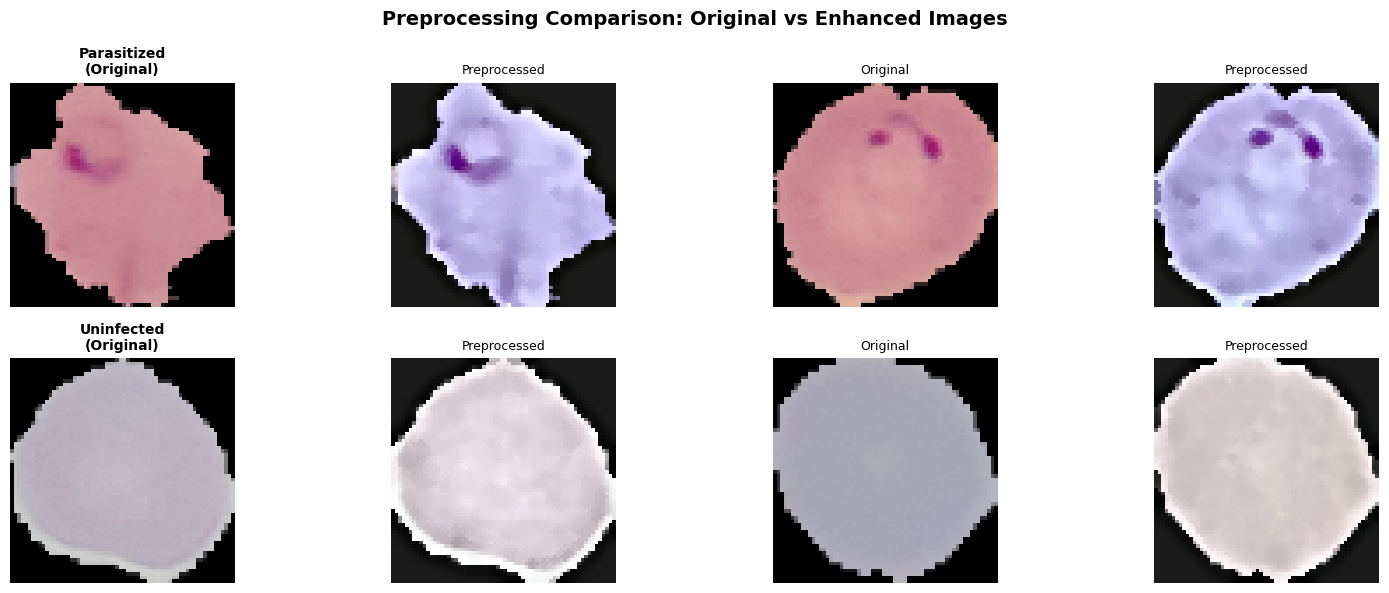

In [12]:
print("\n Visualizing Preprocessing Effect")
visualize_preprocessing(data_dir, categories, samples_per_class=2)

# 3. Split FIRST, then scaling

In [13]:
print("\n Splitting Data and Scaling Features")

X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f" Training samples: {len(X_train)}")
print(f" Test samples: {len(X_test)}")




 Splitting Data and Scaling Features
 Training samples: 22046
 Test samples: 5512


# 5. Logistic Regression + CV

In [14]:
print("\n Training Logistic Regression with Cross-Validation")

log_reg = LogisticRegression(max_iter=2000, C=1.2, solver='lbfgs')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=cv)

print(f"\nCross-validation scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]


 Training Logistic Regression with Cross-Validation

Cross-validation scores: ['0.8431', '0.8469', '0.8546', '0.8449', '0.8387']
Mean CV accuracy: 0.8456 (± 0.0052)


# 6. Confusion Matrix with TP / FP / FN / TN

In [15]:
print("\n Evaluating Model Performance...")

test_acc = accuracy_score(y_test, y_pred)

print(f"TEST ACCURACY: {test_acc:.4f}")


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"{'':>15} Predicted Uninfected  Predicted Parasitized")
print(f"Actual Uninfected:      {tn:>6}                {fp:>6}")
print(f"Actual Parasitized:     {fn:>6}                {tp:>6}")

print(f"\n  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")

print("\n" + classification_report(y_test, y_pred, target_names=categories))



 Evaluating Model Performance...
TEST ACCURACY: 0.8565

Confusion Matrix:
                Predicted Uninfected  Predicted Parasitized
Actual Uninfected:        2347                   409
Actual Parasitized:        382                  2374

  True Negatives (TN):  2347
  False Positives (FP): 409
  False Negatives (FN): 382
  True Positives (TP):  2374

              precision    recall  f1-score   support

 Parasitized       0.86      0.85      0.86      2756
  Uninfected       0.85      0.86      0.86      2756

    accuracy                           0.86      5512
   macro avg       0.86      0.86      0.86      5512
weighted avg       0.86      0.86      0.86      5512



# *7*. ROC Curve

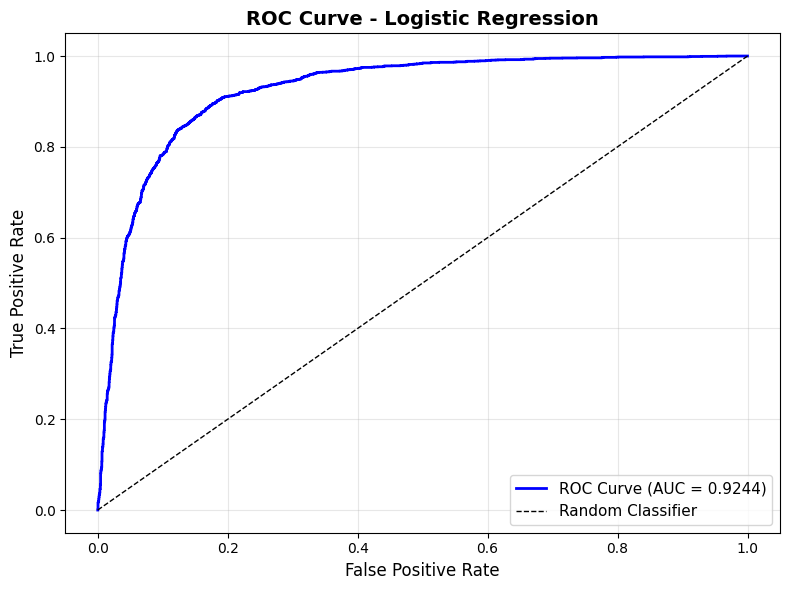

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




# 8. K-Means Clustering

In [17]:
print("\n K-Means Clustering Analysis...")

# Scale features for clustering
scaler_cluster = StandardScaler()
hog_scaled = scaler_cluster.fit_transform(hog_features)

# K-Means++
kmeans = KMeans(
    n_clusters=2,
    init="k-means++",
    n_init=20,
    max_iter=300,
    random_state=42
)

clusters = kmeans.fit_predict(hog_scaled)

print(f"\nCluster distribution: {np.bincount(clusters)}")



 K-Means Clustering Analysis...

Cluster distribution: [18633  8925]


# Clustering Matrices

In [18]:
def clustering_accuracy(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    correct = cm[row_ind, col_ind].sum()
    return correct / len(true_labels)


ari = adjusted_rand_score(labels, clusters)
sil = silhouette_score(hog_scaled, clusters)
clust_acc = clustering_accuracy(labels, clusters)
misclust_rate = 1 - clust_acc

print(f"\n  Adjusted Rand Index:  {ari:.4f}")
print(f"  Silhouette Score:     {sil:.4f}")
print(f"  Clustering Accuracy:  {clust_acc:.4f}")
print(f"  Misclustering Rate:   {misclust_rate:.4f}")
cm_cluster = confusion_matrix(labels, clusters)
print("\nClustering Confusion Matrix:")
print(f"{'':>15} Cluster 0   Cluster 1")
print(f"True Label 0:     {cm_cluster[0][0]:>6}      {cm_cluster[0][1]:>6}")
print(f"True Label 1:     {cm_cluster[1][0]:>6}      {cm_cluster[1][1]:>6}")



  Adjusted Rand Index:  0.0311
  Silhouette Score:     0.0847
  Clustering Accuracy:  0.5883
  Misclustering Rate:   0.4117

Clustering Confusion Matrix:
                Cluster 0   Cluster 1
True Label 0:       8100        5679
True Label 1:      10533        3246


# 9. **PCA Visualisation**


Generating PCA visualization...


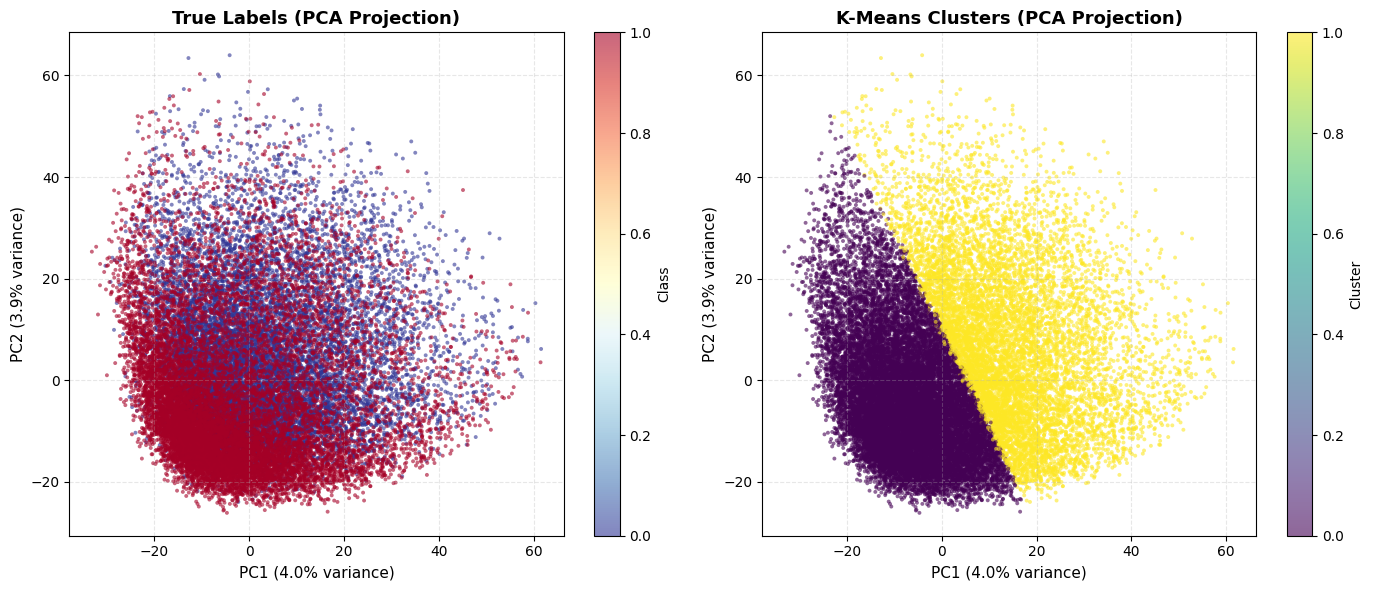

In [19]:
print("\nGenerating PCA visualization...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(hog_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# True labels
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=labels, cmap='RdYlBu_r',
                           s=8, alpha=0.6, edgecolors='none')
axes[0].set_title('True Labels (PCA Projection)',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
                   fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
                   fontsize=11)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Class', fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')

# Clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=clusters, cmap='viridis',
                           s=8, alpha=0.6, edgecolors='none')
axes[1].set_title('K-Means Clusters (PCA Projection)',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
                   fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
                   fontsize=11)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster', fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 10. (ARI + Silhouette) For K-Means

In [20]:
ari = adjusted_rand_score(labels, clusters)
sil = silhouette_score(hog_scaled, clusters)

print("Adjusted Rand Index:", ari)
print("Silhouette Score:", sil)
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(true_labels, cluster_labels):

    cm = confusion_matrix(true_labels, cluster_labels)

    # Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)

    correct = cm[row_ind, col_ind].sum()
    accuracy = correct / len(true_labels)
    return accuracy

Adjusted Rand Index: 0.031147245464263926
Silhouette Score: 0.0847025772072168


# 11. (Accuracy + Misclustring + confuision Matrix ) For K-Means

In [21]:
acc = clustering_accuracy(labels, clusters)
print("Clustering Accuracy:", acc)
def misclustering_rate(true_labels, cluster_labels):
    return 1 - clustering_accuracy(true_labels, cluster_labels)

print("Misclustering rate:", misclustering_rate(labels, clusters))
from sklearn.metrics import confusion_matrix

# confusion matrix between true labels and kmeans clusters
cm = confusion_matrix(labels, clusters)

print("\n===== Confusion Matrix (True vs Cluster) =====")
print(cm)


print("\nFormatted Confusion Matrix:")
print(f"            Cluster 0   Cluster 1")
print(f"True 0 -->    {cm[0][0]:5d}        {cm[0][1]:5d}")
print(f"True 1 -->    {cm[1][0]:5d}        {cm[1][1]:5d}")

Clustering Accuracy: 0.5882865229697366
Misclustering rate: 0.4117134770302634

===== Confusion Matrix (True vs Cluster) =====
[[ 8100  5679]
 [10533  3246]]

Formatted Confusion Matrix:
            Cluster 0   Cluster 1
True 0 -->     8100         5679
True 1 -->    10533         3246
